In [1]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from catboost import Pool, CatBoostRegressor
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [2]:
# catboost optunaで実装

In [3]:
train = pd.read_csv('output.csv')

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
test = pd.read_csv('./data/test.csv')


In [7]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

df = pd.concat([train, test])
rm_cols += ['市区町村コード']
for i, v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [9]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [10]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [11]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [12]:
test[TARGET] = np.nan
train.drop(rm_cols, axis=1, inplace=True)
test.drop(columns=rm_cols, axis=1, inplace=True)


In [13]:
# df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df = pd.concat([train, test])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [14]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [15]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [16]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

In [17]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [18]:

df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
# df['取引_建築'] = df['取引時点'].apply(lambda x: int(x[:4])) - df['建築年']
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.drop(['取引時点'], axis=1, inplace=True)


In [19]:
# 今後の利用目的と建物の構造を削除
df.drop(['今後の利用目的', '建物の構造'], axis=1, inplace=True)


In [20]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,-1,-1,-1
1,1,1,1,1,1,0,0,0,-1


In [21]:
num_feature = [x for x in df.columns if df[x].dtype != 'object']
df[num_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700543 entries, 0 to 700542
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            700543 non-null  int64  
 1   最寄駅：距離（分）     677413 non-null  float64
 2   面積（㎡）         700543 non-null  int64  
 3   建築年           680241 non-null  float64
 4   建ぺい率（％）       676793 non-null  float64
 5   容積率（％）        676793 non-null  float64
 6   取引価格（総額）_log  677392 non-null  float64
 7   取引時点_enc      700543 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 42.8 MB


In [22]:
cat_feature = [x for x in df.columns if df[x].dtype == 'object']
df[cat_feature]

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,神奈川県,横浜市南区,真金町,阪東橋,１Ｋ,住宅,NaN,NaN,NaN
1,東京都,中野区,中央,新中野,１ＬＤＫ,住宅,近隣商業地域,未改装,NaN
2,京都府,京都市伏見区,桃山町丹下,墨染,３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
3,東京都,世田谷区,深沢,都立大学,３ＬＤＫ,住宅,第１種中高層住居専用地域,未改装,NaN
4,埼玉県,さいたま市緑区,原山,浦和,２ＬＤＫ,住宅,NaN,改装済,NaN
...,...,...,...,...,...,...,...,...,...
700538,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
700539,東京都,新宿区,中落合,落合南長崎,１Ｋ,NaN,近隣商業地域,未改装,NaN
700540,東京都,新宿区,中落合,落合南長崎,１Ｋ,住宅,近隣商業地域,改装済,NaN
700541,愛知県,名古屋市千種区,末盛通,覚王山,１ＬＤＫ,住宅,商業地域,NaN,NaN


In [23]:
def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）',
#                                       '面積（㎡）',
#                                       '建ぺい率（％）',
#                                       '容積率（％）'
                                     ],
                        agg_methods=['count', 'mean']
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dis_2 = get_agg_df(df, group_col)
group_col1 = '都道府県名'
agg_dis_pre = get_agg_df(df, group_col1)

In [24]:
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,用途,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
0,14198339,神奈川県,横浜市南区,真金町,阪東橋,NaN,１Ｋ,15,1992.0,住宅,NaN,NaN,NaN,NaN,NaN,6.698970,0
1,13318874,東京都,中野区,中央,新中野,NaN,１ＬＤＫ,40,1999.0,住宅,近隣商業地域,80.0,400.0,未改装,NaN,7.380211,0
2,26081806,京都府,京都市伏見区,桃山町丹下,墨染,4.0,３ＬＤＫ,60,1994.0,住宅,第１種住居地域,60.0,200.0,未改装,NaN,7.176091,0
3,13302280,東京都,世田谷区,深沢,都立大学,NaN,３ＬＤＫ,85,2004.0,住宅,第１種中高層住居専用地域,60.0,200.0,未改装,NaN,7.832509,0
4,11089836,埼玉県,さいたま市緑区,原山,浦和,NaN,２ＬＤＫ,50,1990.0,住宅,NaN,NaN,NaN,改装済,NaN,6.977724,0


In [25]:
feat_df = pd.concat([df[num_feature], le_df, agg_dis_2, agg_dis_pre], axis=1)

In [26]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,...,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,...,0,0,0,-1,-1,-1,3694,8.494857,95841,13.536514
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,...,1,1,0,0,0,-1,4524,6.402078,201943,7.800889
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,...,2,2,0,1,0,-1,1908,9.590147,15959,10.065982
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,...,3,2,0,2,0,-1,11256,8.792822,201943,7.800889
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,...,4,3,0,-1,1,-1,548,19.826642,41539,13.331857


In [27]:
feat_df['距離_bin'] = pd.cut(feat_df['最寄駅：距離（分）'], [0, 30, 45, 75, 120], labels=False)

In [28]:
nulti = feat_df['面積（㎡）'] * feat_df['容積率（％）']
feat_df['容積_面積'] = nulti

In [29]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,...,用途,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,距離_bin,容積_面積
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,...,0,-1,-1,-1,3694,8.494857,95841,13.536514,NaN,NaN
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,...,0,0,0,-1,4524,6.402078,201943,7.800889,NaN,16000.0
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,...,0,1,0,-1,1908,9.590147,15959,10.065982,0.0,12000.0
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,...,0,2,0,-1,11256,8.792822,201943,7.800889,NaN,17000.0
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,...,0,-1,1,-1,548,19.826642,41539,13.331857,NaN,NaN


In [30]:
feat_df['距離'] = feat_df['agg_count_最寄駅：距離（分）_grpby_都道府県名'] / (feat_df['agg_count_最寄駅：距離（分）_grpby_市区町村名']+1)

In [31]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 24) (24899, 24) (23151, 24)


In [32]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [33]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

<AxesSubplot:>

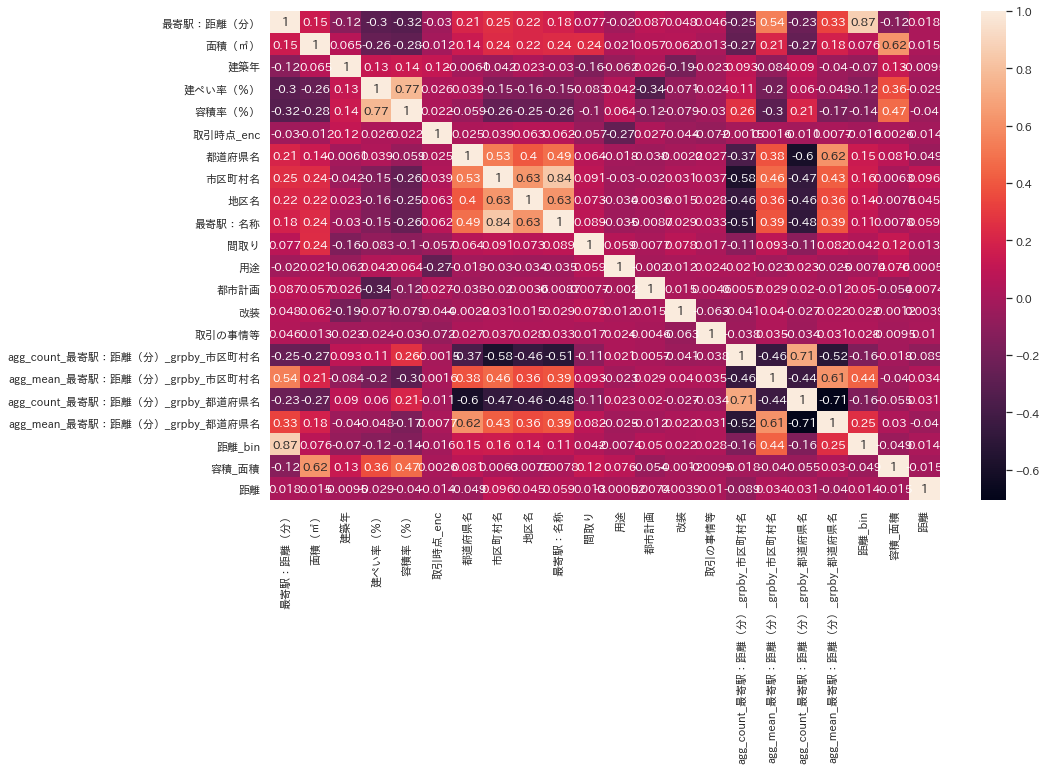

In [35]:
fig = plt.figure(figsize=(15,9))
sns.heatmap(train_x.corr(), annot=True)

In [36]:
cat_cols = list(le_df.columns)
cat_cols

['都道府県名', '市区町村名', '地区名', '最寄駅：名称', '間取り', '用途', '都市計画', '改装', '取引の事情等']

In [37]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.35),
#         'has_time':True,
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 100),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
#         'objective':'regression',
#         'metric':'mae',
#         'num_boost_round':50000,
#         'early_stopping_rounds':100,
#         'random_state':0,
    }
    
    model = CatBoostRegressor(**params)
    
    model.fit(train_pool,
             eval_set=[valid_pool],
             verbose=100
             )
    
    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)
    return mae

In [38]:
train_pool = Pool(train_x, train_y, cat_features=cat_cols)
valid_pool = Pool(val_x, val_y, cat_features=cat_cols)
study = optuna.create_study()
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2022-01-04 11:14:14,019] A new study created in memory with name: no-name-db11f9d3-2b84-4836-b881-50b312d8eda9


Learning rate set to 0.19709
0:	learn: 0.3169931	test: 0.3263783	best: 0.3263783 (0)	total: 508ms	remaining: 5m 51s
100:	learn: 0.1505037	test: 0.1534715	best: 0.1534715 (100)	total: 25.9s	remaining: 2m 31s
200:	learn: 0.1403230	test: 0.1418469	best: 0.1418469 (200)	total: 54.8s	remaining: 2m 14s
300:	learn: 0.1368747	test: 0.1377756	best: 0.1377756 (300)	total: 1m 30s	remaining: 1m 58s
400:	learn: 0.1348739	test: 0.1357855	best: 0.1357855 (400)	total: 1m 57s	remaining: 1m 25s
500:	learn: 0.1334361	test: 0.1343747	best: 0.1343729 (499)	total: 2m 26s	remaining: 56s
600:	learn: 0.1322047	test: 0.1333355	best: 0.1333355 (600)	total: 2m 54s	remaining: 26.7s
692:	learn: 0.1313832	test: 0.1326391	best: 0.1326391 (692)	total: 3m 20s	remaining: 0us

bestTest = 0.1326390609
bestIteration = 692



[I 2022-01-04 11:17:36,446] Trial 0 finished with value: 0.08328326418739704 and parameters: {'iterations': 693, 'random_strength': 37, 'bagging_temperature': 1.2725555730962193, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 0 with value: 0.08328326418739704.


Learning rate set to 0.409821
0:	learn: 0.2957359	test: 0.3052834	best: 0.3052834 (0)	total: 283ms	remaining: 1m
100:	learn: 0.1442911	test: 0.1456591	best: 0.1456591 (100)	total: 27.8s	remaining: 31.1s
200:	learn: 0.1377834	test: 0.1391028	best: 0.1391028 (200)	total: 56s	remaining: 3.62s
213:	learn: 0.1373112	test: 0.1387097	best: 0.1387097 (213)	total: 1m	remaining: 0us

bestTest = 0.1387097314
bestIteration = 213



[I 2022-01-04 11:18:37,409] Trial 1 finished with value: 0.0880197108469044 and parameters: {'iterations': 214, 'random_strength': 94, 'bagging_temperature': 4.03228744736098, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 0 with value: 0.08328326418739704.


Learning rate set to 0.183974
0:	learn: 0.3243588	test: 0.3341134	best: 0.3341134 (0)	total: 308ms	remaining: 3m 58s
100:	learn: 0.1527422	test: 0.1574034	best: 0.1574034 (100)	total: 32s	remaining: 3m 33s
200:	learn: 0.1410187	test: 0.1425144	best: 0.1425144 (200)	total: 1m 5s	remaining: 3m 6s
300:	learn: 0.1374519	test: 0.1386979	best: 0.1386979 (300)	total: 1m 33s	remaining: 2m 26s
400:	learn: 0.1352425	test: 0.1365860	best: 0.1365860 (400)	total: 2m 2s	remaining: 1m 53s
500:	learn: 0.1337854	test: 0.1351324	best: 0.1351324 (500)	total: 2m 33s	remaining: 1m 23s
600:	learn: 0.1326729	test: 0.1341567	best: 0.1341567 (600)	total: 3m 3s	remaining: 52.7s
700:	learn: 0.1318137	test: 0.1333648	best: 0.1333602 (699)	total: 3m 33s	remaining: 22.2s
773:	learn: 0.1311992	test: 0.1328847	best: 0.1328847 (773)	total: 3m 54s	remaining: 0us

bestTest = 0.1328846644
bestIteration = 773



[I 2022-01-04 11:22:34,180] Trial 2 finished with value: 0.083049247884902 and parameters: {'iterations': 774, 'random_strength': 56, 'bagging_temperature': 1.5250852989949586, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.237995
0:	learn: 0.3043883	test: 0.3158675	best: 0.3158675 (0)	total: 229ms	remaining: 1m 56s
100:	learn: 0.1429790	test: 0.1443739	best: 0.1443739 (100)	total: 25.7s	remaining: 1m 44s
200:	learn: 0.1370525	test: 0.1376808	best: 0.1376808 (200)	total: 54.3s	remaining: 1m 24s
300:	learn: 0.1345617	test: 0.1357393	best: 0.1357380 (299)	total: 1m 22s	remaining: 58s
400:	learn: 0.1329247	test: 0.1341517	best: 0.1341517 (400)	total: 1m 58s	remaining: 32.8s
500:	learn: 0.1317086	test: 0.1327399	best: 0.1327385 (499)	total: 2m 30s	remaining: 3.31s
511:	learn: 0.1315703	test: 0.1326443	best: 0.1326443 (511)	total: 2m 34s	remaining: 0us

bestTest = 0.1326443046
bestIteration = 511



[I 2022-01-04 11:25:10,444] Trial 3 finished with value: 0.08324381031148635 and parameters: {'iterations': 512, 'random_strength': 5, 'bagging_temperature': 95.18590217297462, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.326644
0:	learn: 0.2999614	test: 0.3101122	best: 0.3101122 (0)	total: 327ms	remaining: 1m 40s
100:	learn: 0.1439673	test: 0.1455988	best: 0.1455988 (100)	total: 25.8s	remaining: 52.9s
200:	learn: 0.1370906	test: 0.1372313	best: 0.1372313 (200)	total: 52.2s	remaining: 27.8s
300:	learn: 0.1343933	test: 0.1343098	best: 0.1343098 (300)	total: 1m 18s	remaining: 1.83s
307:	learn: 0.1341808	test: 0.1341311	best: 0.1341311 (307)	total: 1m 20s	remaining: 0us

bestTest = 0.1341310571
bestIteration = 307



[I 2022-01-04 11:26:32,143] Trial 4 finished with value: 0.08528544368728032 and parameters: {'iterations': 308, 'random_strength': 45, 'bagging_temperature': 23.603932140788032, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.246799
0:	learn: 0.3100496	test: 0.3198762	best: 0.3198762 (0)	total: 486ms	remaining: 3m 54s
100:	learn: 0.1465896	test: 0.1495660	best: 0.1495660 (100)	total: 31.3s	remaining: 1m 58s
200:	learn: 0.1385302	test: 0.1396076	best: 0.1396076 (200)	total: 57.7s	remaining: 1m 20s
300:	learn: 0.1354504	test: 0.1362865	best: 0.1362865 (300)	total: 1m 24s	remaining: 51s
400:	learn: 0.1335780	test: 0.1342732	best: 0.1342732 (400)	total: 1m 50s	remaining: 22.7s
482:	learn: 0.1323293	test: 0.1331198	best: 0.1331198 (482)	total: 2m 12s	remaining: 0us

bestTest = 0.1331197932
bestIteration = 482



[I 2022-01-04 11:28:46,541] Trial 5 finished with value: 0.08416152457689773 and parameters: {'iterations': 483, 'random_strength': 53, 'bagging_temperature': 0.10981779628658915, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.38058
0:	learn: 0.2830095	test: 0.2938544	best: 0.2938544 (0)	total: 314ms	remaining: 1m 15s
100:	learn: 0.1414799	test: 0.1424291	best: 0.1424291 (100)	total: 25.8s	remaining: 35.7s
200:	learn: 0.1357643	test: 0.1362189	best: 0.1362189 (200)	total: 54.9s	remaining: 10.9s
240:	learn: 0.1345715	test: 0.1352862	best: 0.1352862 (240)	total: 1m 6s	remaining: 0us

bestTest = 0.1352862376
bestIteration = 240



[I 2022-01-04 11:29:53,872] Trial 6 finished with value: 0.08597954555182666 and parameters: {'iterations': 241, 'random_strength': 26, 'bagging_temperature': 0.10457411779377253, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.462901
0:	learn: 0.2747538	test: 0.2837789	best: 0.2837789 (0)	total: 93.7ms	remaining: 16.4s
100:	learn: 0.1409914	test: 0.1427143	best: 0.1427143 (100)	total: 5.97s	remaining: 4.44s


[I 2022-01-04 11:30:04,461] Trial 7 finished with value: 0.08855337960030939 and parameters: {'iterations': 176, 'random_strength': 34, 'bagging_temperature': 92.87157994403731, 'od_type': 'Iter', 'od_wait': 11}. Best is trial 2 with value: 0.083049247884902.


175:	learn: 0.1365659	test: 0.1380420	best: 0.1380420 (175)	total: 10.1s	remaining: 0us

bestTest = 0.1380420257
bestIteration = 175

Learning rate set to 0.229964
0:	learn: 0.3090402	test: 0.3192070	best: 0.3192070 (0)	total: 306ms	remaining: 2m 45s
100:	learn: 0.1464749	test: 0.1484662	best: 0.1484662 (100)	total: 24.8s	remaining: 1m 48s
200:	learn: 0.1387751	test: 0.1397700	best: 0.1397700 (200)	total: 50.4s	remaining: 1m 25s
300:	learn: 0.1356093	test: 0.1363588	best: 0.1363588 (300)	total: 1m 17s	remaining: 1m 1s
400:	learn: 0.1337450	test: 0.1345177	best: 0.1345177 (400)	total: 1m 43s	remaining: 36.3s
500:	learn: 0.1324119	test: 0.1332328	best: 0.1332328 (500)	total: 2m 9s	remaining: 10.4s
540:	learn: 0.1319455	test: 0.1329524	best: 0.1329524 (540)	total: 2m 20s	remaining: 0us

bestTest = 0.13295244
bestIteration = 540



[I 2022-01-04 11:32:25,960] Trial 8 finished with value: 0.08370381599202657 and parameters: {'iterations': 541, 'random_strength': 26, 'bagging_temperature': 4.292403022654826, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 2 with value: 0.083049247884902.


Learning rate set to 0.369231
0:	learn: 0.2938859	test: 0.3041456	best: 0.3041456 (0)	total: 309ms	remaining: 1m 17s
100:	learn: 0.1429632	test: 0.1450666	best: 0.1450666 (100)	total: 24s	remaining: 36.1s
200:	learn: 0.1365138	test: 0.1372184	best: 0.1372184 (200)	total: 49.1s	remaining: 12.7s
252:	learn: 0.1347613	test: 0.1356723	best: 0.1356723 (252)	total: 1m 2s	remaining: 0us

bestTest = 0.1356722627
bestIteration = 252



[I 2022-01-04 11:33:29,492] Trial 9 finished with value: 0.08652296195747852 and parameters: {'iterations': 253, 'random_strength': 51, 'bagging_temperature': 12.357222146471079, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 2 with value: 0.083049247884902.


FrozenTrial(number=2, values=[0.083049247884902], datetime_start=datetime.datetime(2022, 1, 4, 11, 18, 37, 410088), datetime_complete=datetime.datetime(2022, 1, 4, 11, 22, 34, 180240), params={'iterations': 774, 'random_strength': 56, 'bagging_temperature': 1.5250852989949586, 'od_type': 'IncToDec', 'od_wait': 32}, distributions={'iterations': IntUniformDistribution(high=1000, low=50, step=1), 'random_strength': IntUniformDistribution(high=100, low=0, step=1), 'bagging_temperature': LogUniformDistribution(high=100.0, low=0.1), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntUniformDistribution(high=50, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)


In [43]:
study.best_params

{'iterations': 774,
 'random_strength': 56,
 'bagging_temperature': 1.5250852989949586,
 'od_type': 'IncToDec',
 'od_wait': 32}

In [47]:
best_params = {
               'learning_rate': 0.183974,
               'random_strength': 56,
               'bagging_temperature': 1.5250852989949586,
               'od_type': 'IncToDec',
               'od_wait': 32,
               'n_estimators':10000,
               'loss_function':'MAE',
               'random_state':0
}

In [48]:
cat = CatBoostRegressor(**(best_params))
train_pool = Pool(train_x, train_y, cat_features=cat_cols)
valid_pool = Pool(val_x, val_y, cat_features=cat_cols)

In [49]:

model = cat.fit(
    train_pool, 
    eval_set=valid_pool,
    verbose = 100,
    early_stopping_rounds=100
)

0:	learn: 0.2454437	test: 0.2463122	best: 0.2463122 (0)	total: 312ms	remaining: 51m 59s
100:	learn: 0.1023795	test: 0.1049956	best: 0.1049956 (100)	total: 31.3s	remaining: 51m 3s
200:	learn: 0.0898220	test: 0.0913128	best: 0.0913128 (200)	total: 1m 5s	remaining: 53m 10s
300:	learn: 0.0861900	test: 0.0873801	best: 0.0873801 (300)	total: 1m 42s	remaining: 55m 1s
400:	learn: 0.0842224	test: 0.0853535	best: 0.0853535 (400)	total: 2m 21s	remaining: 56m 31s
500:	learn: 0.0828391	test: 0.0840293	best: 0.0840293 (500)	total: 2m 58s	remaining: 56m 31s
600:	learn: 0.0816956	test: 0.0829750	best: 0.0829750 (600)	total: 3m 31s	remaining: 55m 3s
700:	learn: 0.0808486	test: 0.0821929	best: 0.0821929 (700)	total: 4m 4s	remaining: 54m 2s
800:	learn: 0.0800770	test: 0.0815478	best: 0.0815478 (800)	total: 4m 38s	remaining: 53m 17s
900:	learn: 0.0794782	test: 0.0810802	best: 0.0810802 (900)	total: 5m 12s	remaining: 52m 31s
1000:	learn: 0.0789339	test: 0.0806541	best: 0.0806541 (1000)	total: 5m 45s	remain